<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/tda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Classical TDA (Persistent Homology)**

Please see the [slides deck](https://docs.google.com/presentation/d/11JoNDMu0gIOpCASB9YTEFMgpnYccRz4RYJSvLvyqTDw/edit#slide=id.g11b499b2d6d_0_1112) for summary of results

#### <font color="blue">**Import Libraries & Data**

In [37]:
# Fundamental Libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
# Libraries for Statistical Analysis
from scipy import stats                                 # Statistical Functions module from Scipy
import statsmodels.api as sm                            # Autocorrelation Value
from statsmodels.graphics.tsaplots import plot_acf      # Autocorrelation Function Plot
from statsmodels.graphics.tsaplots import plot_pacf     # Partial Autocorrelation Function Plot
from pandas.plotting import lag_plot                    # Lag Plot
from statsmodels.tsa.seasonal import seasonal_decompose # Time Series Decomposition
from statsmodels.tsa.stattools import adfuller          # Augmented Dickey Fuller Test (for stationarity / unit root)

In [39]:
# Libraries for Topological Data Analysis
!pip install -U giotto-tda --q                          # Complete TDA library from Giotto
from gtda.time_series import SingleTakensEmbedding      # Create Takens Embedding of Time Series
from gtda.plotting import plot_point_cloud              # Plot pointcloud from Takens Embedding in phase space
from gtda.diagrams import PersistenceLandscape          # Create persistence landscape from Takens Embedding
from gtda.diagrams import BettiCurve                    # Create Betti Curves
from gtda.homology import VietorisRipsPersistence       # Create persistence diagrams of the VietorisRips filtration
from gtda.homology import EuclideanCechPersistence      # Create persistence diagrams of the Čech filtration
from gtda.homology import WeightedRipsPersistence       # Create persistence diagrams of the Weighted (Vietoris–)Rips filtrations
from gtda.homology import WeakAlphaPersistence          # Create persistence diagrams of the Weak Alpha filtration
from gtda.homology import SparseRipsPersistence         # Create persistence diagrams of the SparseRips filtration

In [40]:
# Import raw data and display table content
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sp500c.csv'
data_raw = pd.read_csv(url)
data_raw.head()

,Date,Open,High,Low,Close
0,05/24/22,3942.94,3955.68,3875.13,3941.48
1,05/23/22,3919.42,3981.88,3909.04,3973.75
2,05/20/22,3927.76,3943.42,3810.32,3901.36
3,05/19/22,3899.00,3945.96,3876.58,3900.79
4,05/18/22,4051.98,4051.98,3911.91,3923.68


#### <font color="blue">**Data Preparation**

##### **Basic Data Preprocessing**

<font color="blue">*We cannot continue working with the raw data. We need to remove unnessary columns, add a proper datetime and reverse its order. First, we rename 'data_raw' into 'data'. If mistakes happen in data processing later, then run this line instead instead of re-importing all data.*

In [41]:
# Rename imported time series
data = data_raw

<font color="blue">*Now we make basic feature preparation - choose the desired column, add proper datetime, etc*

In [42]:
# Select specific features, and rename features
data = data[['Date', 'Open', 'High', 'Low', 'Close']].rename(columns={"Date": "date", "Close": "price"})
data = data.drop(['Open', 'High', 'Low'], axis=1)

# Set date index
data = data.set_index('date')

# Add Frequency (business days)
data.index = pd.to_datetime(data.index, utc=True)
data = data.asfreq('B') # B stands for business day, so that weekends and bank holiday as non trading day are ignored

# Remove nan
data = data.dropna()

# Display table
data.head()

,price
date,
1997-01-02 00:00:00+00:00,737.01
1997-01-03 00:00:00+00:00,748.03
1997-01-06 00:00:00+00:00,747.65
1997-01-07 00:00:00+00:00,753.23
1997-01-08 00:00:00+00:00,748.41


In [43]:
data_original = data # We will need this later to differentiate between preprocessed and original data

##### **Statistical Data Analysis**

<font color="blue">*Let's first visualize the time series and call some basic statistical properties:*

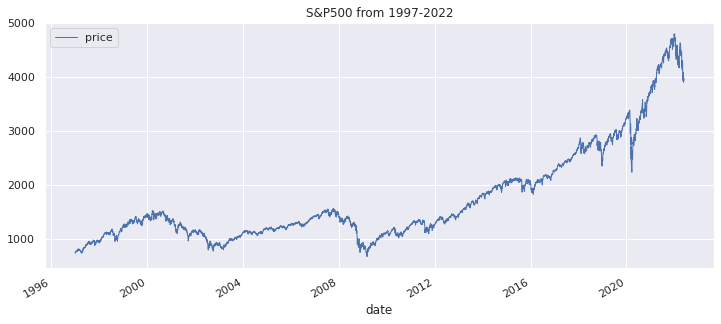

In [44]:
# Visualize Time Series
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})
data.plot(title='S&P500 from 1997-2022')

<font color="blue">*Here we can see two properties: first, a strong drift upwards. However we cannot determine if its cointegrated (non stationary), because there exist also trend-stationarity time series (we will use the Augmented Dickey Fuller to test). Secondly, we can see the 4 major downturns: 2000, 2008, 2020 and 2022. We will focus on these for our TDA later*

In [45]:
# Get Exploratory Statistical Information
data.describe()

,price
count,6392.000000
mean,1732.948364
std,894.703367
min,676.530000
25%,1136.377500
50%,1360.025000
75%,2090.102500
max,4796.560000


**Test for Autocorrelation**

<font color="blue">*We need to test for autocorrelation for two reasons:*

* <font color="blue">*First, we need that information to define an upper bound to define the 'time delay' in Takens Time Delay Embedding (the concrete value for this parameter will then be computed by mutual information criterion)*

* <font color="blue">*Second, it is one source of information to learn if and to which degree the time series is stationary or not. The autocorrelation function (ACF) declines to near zero rapidly for a stationary time series, and slowly for a non-stationary time series. Nonstationarity should be treated with a data transformation (i.e. differencing or logreturn)*

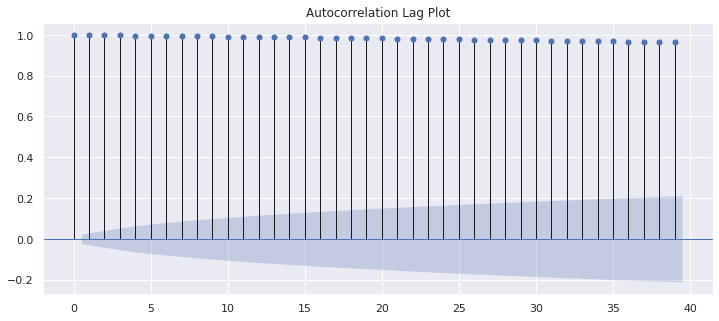

In [46]:
plot_acf(data)
plt.title('Autocorrelation Lag Plot')
plt.show()

* <font color="blue">*The overall ACF drops slowly, which shows that the time series is nonstationary. We will look into that a bit deeper later on. Now let's turn to the partial ACF, which helps us better to determine the upper bound to define the 'time delay' in Takens Time Delay Embedding:*

* <font color="blue">*The partial autocorrelation function is similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain.*

* <font color="blue">*For example, the partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between those two observations after partialling out the intervening correlations.*

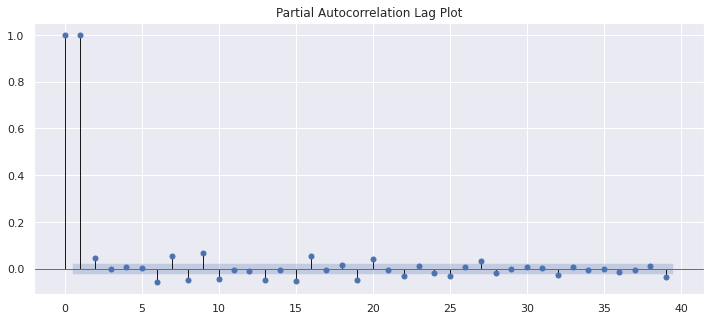

In [47]:
plot_pacf(data)
plt.title('Partial Autocorrelation Lag Plot')
plt.show()

In [48]:
#calculate partial autocorrelation values
sm.tsa.pacf(data)

array([ 1.00000000e+00,  9.99275275e-01,  4.38296951e-02,  7.25438936e-04,
        8.80045119e-03,  5.13511417e-03, -5.65851740e-02,  5.37139054e-02,
       -4.98743675e-02,  6.84548462e-02, -4.18566320e-02, -5.36925463e-03,
       -1.11210635e-02, -4.76418247e-02, -6.45307225e-03, -5.31597442e-02,
        5.42738688e-02, -6.71687303e-03,  1.63539226e-02, -4.69360724e-02,
        3.98302609e-02, -4.14198480e-03, -3.26446906e-02,  1.08895118e-02,
       -1.82475302e-02, -3.15333859e-02,  8.35071728e-03,  3.12616107e-02,
       -1.68988946e-02, -1.44172931e-03,  6.52732053e-03,  3.57914786e-03,
       -2.66805786e-02,  5.22202621e-03, -5.42184954e-03, -2.29712807e-03,
       -1.32457548e-02, -4.06400350e-03,  1.02199668e-02, -3.39521247e-02,
       -2.48881243e-02])

* <font color="blue">*On the graph, the partial autocorrelations for lags 1 and 2 are statistically significant. The subsequent lags are nearly significant.*

* <font color="blue">*We can see the near efficient market hypothesis: autocorrelation exists only at 1-2 lags. Financial time series are Markov processes, where you can only use one step or a few steps to forecast a given value. Beyond, there is not much information anymore for forecasting accurately*

* <font color="blue">*This PACF suggests to difference or logreturn the time series (i.e. for fitting either a second or third-order autoregressive model), and using an upper bound of 2 or 3.*

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


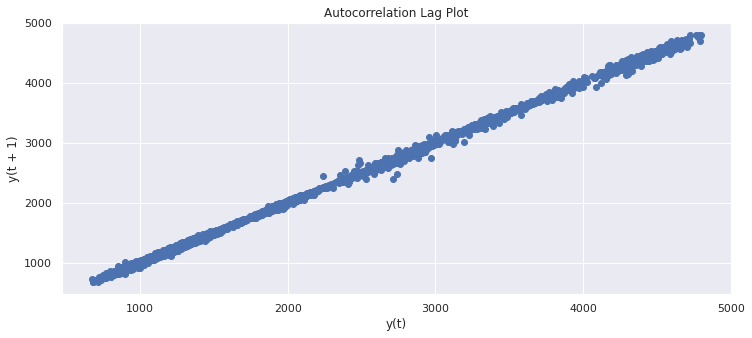

In [49]:
lag_plot(data)
plt.title('Autocorrelation Lag Plot')
plt.show()

**Is the time series stationary or not?**

<font color="blue">*To see whether the series is stationary or not, let's have a deeper look into this topic by starting with a simple time series decomposition*

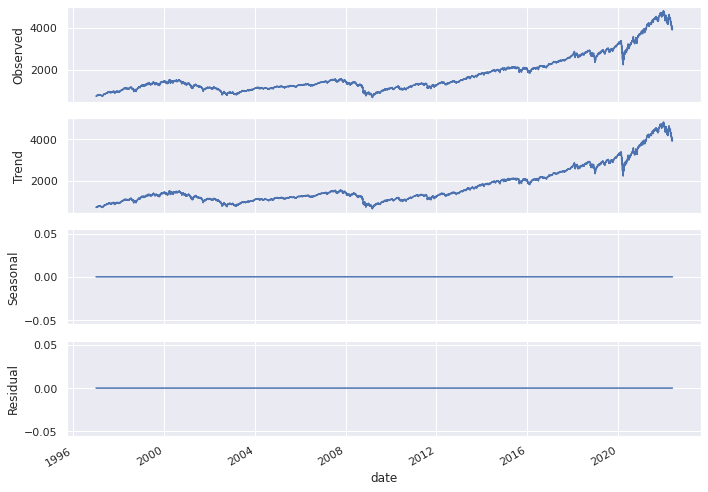

In [50]:
sns.set(rc={'figure.figsize':(10, 7)})
decompose = data
result = seasonal_decompose(decompose, model='additive', freq=1) # or multiplicative approach
# print(result.trend)     # Get numerical details if desired
# print(result.seasonal)  # Get numerical details if desired
# print(result.resid)     # Get numerical details if desired
# print(result.observed)  # Get numerical details if desired
result.plot()
plt.show()

<font color="blue">*The previous decomposition method recognizes a trend, but doesn't seem to find any seasonalities. Let's use another decomposition to verify if there is seasonality or not:*

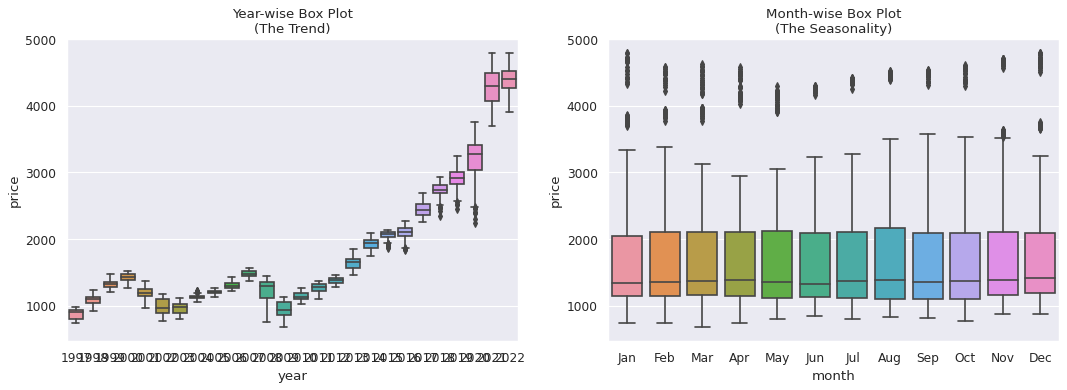

In [51]:
# Import Data
seasonal_plots = data.copy()

# Transform Series
seasonal_plots.reset_index(inplace=True)
seasonal_plots = seasonal_plots.rename(columns={"ts": "date", "feature" : "price"})

# Prepare Data
seasonal_plots['year'] = [d.year for d in seasonal_plots.date]
seasonal_plots['month'] = [d.strftime('%b') for d in seasonal_plots.date]
years = seasonal_plots['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(16,5), dpi= 80)
sns.boxplot(x='year', y='price', data=seasonal_plots, ax=axes[0])
sns.boxplot(x='month', y='price', data=seasonal_plots.loc[~seasonal_plots.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=12); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=12)

plt.show()

<font color="blue">*Now we can see that the time series has a strong trend upwards (drift), and also a slight seasonality. Let's use a statistical test to verify non stationarity. With this information we will be sure that we need to transform the time series in order to remove for obvious patterns (that simple forecasting methods can pick up), such as trends or seasonalities. We will use the Augmented Dicker Fuller test:*

In [52]:
# Augmented Dickey Fuller. H0: There is a unit root for the series (non stationary)
adfuller(data.price, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)

(-3.323683002444231,
 0.16430061146012542,
 28,
 6363,
 {'1%': -4.372952070959216,
  '10%': -3.5538352684913024,
  '5%': -3.833318440331927},
 57173.11216853703)

<font color="blue">About the Test:</font>
* Null hypothesis is that there is a unit root = time series is not stationary. 
* The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.
* Augmented Dickey–Fuller test for a larger and more complicated set of time series models (opposed to Dickey–Fuller), which we have here (see above under general statistical properties = 6392 data points).
* The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.
* We can reject the Null hypothesis (which would mean that the time series is stationary) if 
  * p-value < 0.05 (if we take 5% significance level or 95% confidence interval) or
  * critical value < T-values (t-values at 1%, 5% and 10% confidence intervals)

* *Technical documentation: [Statsmodel.adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html)*

* *Econometric background about [Augmented Dickey–Fuller test
](https://en.m.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)*

<font color="blue">Measurement results:</font>
* First data point: -3.323683002444231: Critical value of the data
* Second data point: 0.16430061146012542 = p-value
* Third data point: 28: Number of lags used in regression to determine t-statistic.
* Forth data point: 6363: Number of observations used
* Fifth data point: T values corresponding to adfuller test
  * 1%: -4.372952070959216
  * 10%: -3.5538352684913024
  * 5%: -3.833318440331927

<font color="blue">Interpretation:</font>
* p-value of 0.16 > 0.05, null hypothesis cannot be rejected. 
* Critical value -3.3 > -4.3, -3.5, -3.8 (t-values at 1%, 5% and 10% confidence intervals), null hypothesis can not be rejected.


<font color="blue">*Result: We can not reject the null hypothesis, which means that the time series is <u>not</u> stationary  (it has no more relation with time). There is a unit root and it would be beneficial to difference or logreturn the time series.*


**What is the distribution of the time series?**

<font color="blue">*This question is important to decide whether we normalize our time series (distribution is unknown or non-Gaussian) or standardize (distribution is assumed to be Gaussian). We can use statistical plots or statistical 'goodness of fit' tests*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



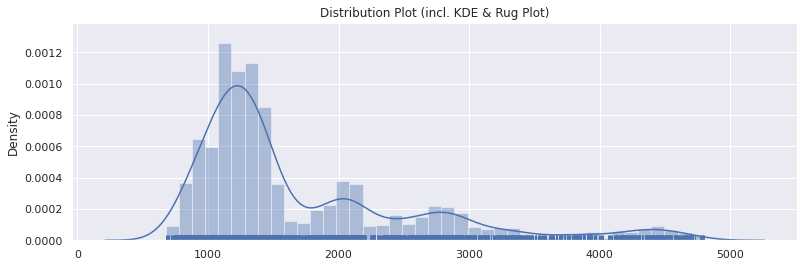

In [53]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((data), hist=True, rug=True).set_title('Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

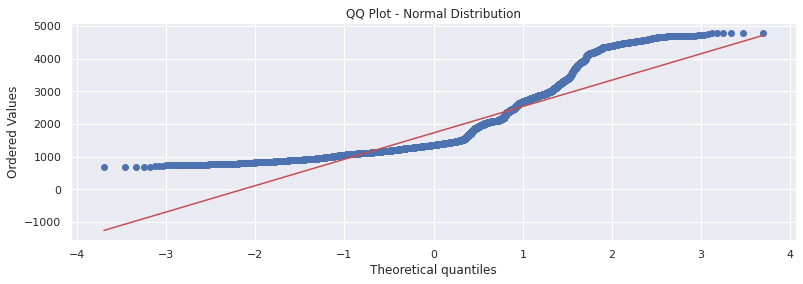

In [54]:
stats.probplot(data.price, dist="norm", plot=plt)
plt.title('QQ Plot - Normal Distribution')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Boxplot')

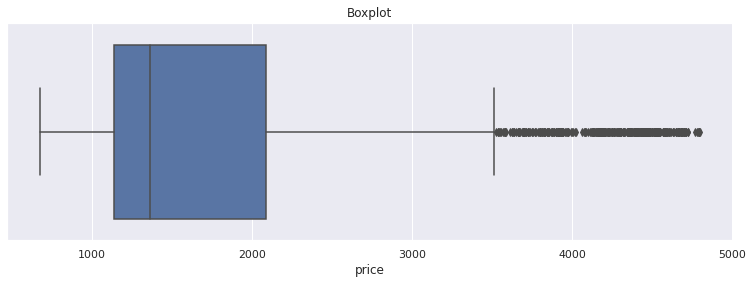

In [55]:
sns.boxplot(data.price).set_title('Boxplot')

In [56]:
#Shapiro–Wilk Test
stats.shapiro(data.price)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning:

p-value may not be accurate for N > 5000.



(0.8133988976478577, 0.0)

In [57]:
# Normal Test. H0: sample comes from a normal distribution
# stats.normaltest(data)

k2, p = stats.normaltest(data.price)
print("p = {:g}".format(p))

alpha = 1e-3
if (p < alpha):
  print("The null hypothesis that x comes from a normal distribution can be rejected")
else:
  print("The null hypothesis that x comes from a normal distribution cannot be rejected")

p = 0
The null hypothesis that x comes from a normal distribution can be rejected


<font color="blue">*Summary: Time Series is clearly not normally distributed. We will normalize the time series, and not standardize.*

##### **Feature Preparation**

*Logreturn the time series*

<font color="blue">*Let's display the original time series first, then we take the logreturn and then display the transformed time series. Taking the logreturn is a common method when working with financial time series (raw values have normally negligible influence compared to previous time step price.*

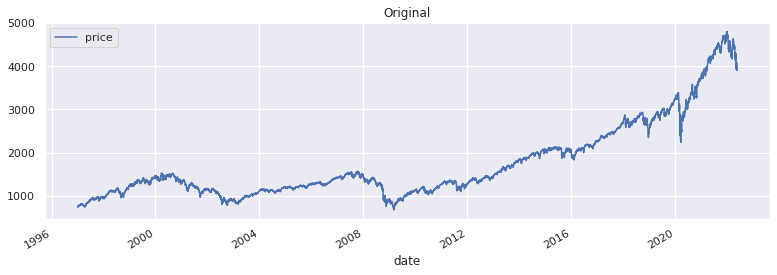

In [58]:
data.plot(title='Original')

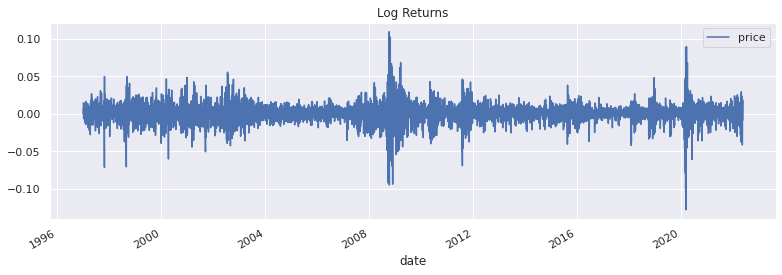

In [59]:
# Log Return
data = np.log(data/data.shift(1)).dropna()
data.plot(title='Log Returns')

<font color="blue">*Let's run the Augmented Dickey Fuller test again to check for non-stationarity:*

In [60]:
adfuller(data.price, maxlag=None, regression='ctt', autolag='AIC', store=False, regresults=False)

(-14.633804375729321,
 1.6740337755490877e-23,
 33,
 6357,
 {'1%': -4.3729537915435275,
  '10%': -3.5538358115775126,
  '5%': -3.8333193169246886},
 -37877.03211013526)

<font color="blue">*p-value 1.6740337755490877e-23 < 0.05 (if we take 5% significance level or 95% confidence interval). Critical value is -14.633804375729321 < T values corresponding to adfuller test -4.37, -3.55 and -3.83).*

<font color="blue">*Result: Null hypothesis can be rejected, time series is stationary now. Obvious trends or seasonalities are removed.*

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



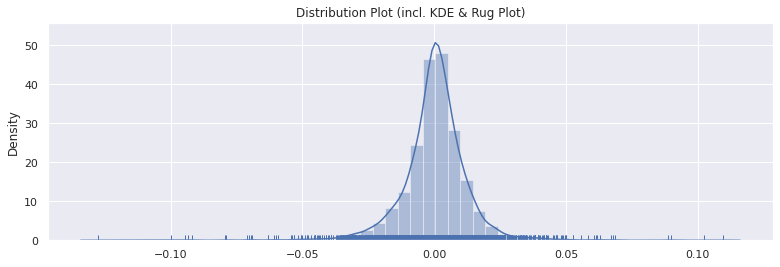

In [61]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((data), hist=True, rug=True).set_title('Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

In [62]:
# Get Exploratory Statistical Information
data.describe()

,price
count,6391.000000
mean,0.000262
std,0.012382
min,-0.127652
25%,-0.004904
50%,0.000672
75%,0.006084
max,0.109572


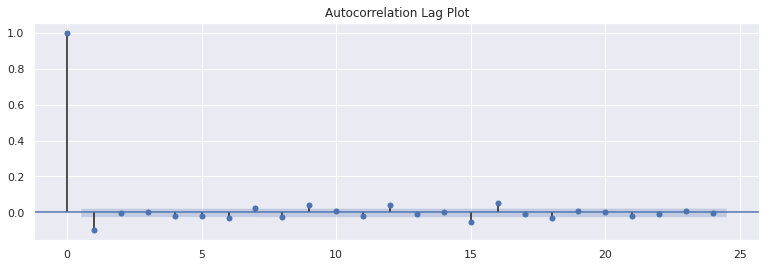

In [63]:
plot_acf(data, lags=24)
plt.title('Autocorrelation Lag Plot')
plt.show()

<font color="blue">*We still have an autocorrelation of lag 1 or 2, which is a useful information for the embedding_time_delay in Takens Embedding later.*

*Normalize the time series*

<font color="blue">*It is good practice to normalize the time series before working with it. The normalization doesn't seem to have an impact on the TDA results later, which means it may be indifferent to do this or not. We will use min-max normalization.*

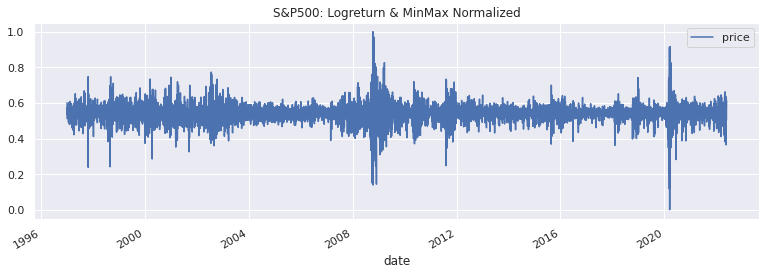

In [64]:
# data = (data-data.mean())/data.std()            # Mean Normalization
data = (data-data.min())/(data.max()-data.min())  # Min Max Normalization
data = data.dropna()                              # remove nan value
data.plot(title='S&P500: Logreturn & MinMax Normalized')

In [65]:
# Get Exploratory Statistical Information
data.describe()

,price
count,6391.000000
mean,0.539214
std,0.052195
min,0.000000
25%,0.517435
50%,0.540942
75%,0.563753
max,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



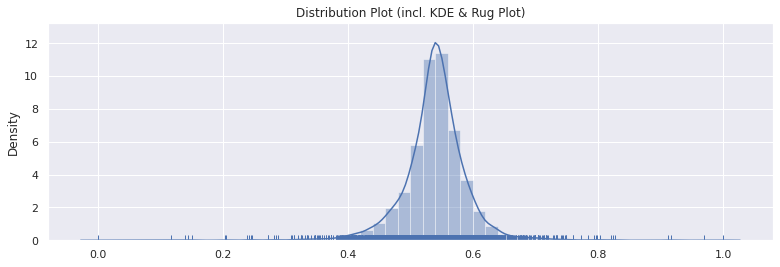

In [66]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((data), hist=True, rug=True).set_title('Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

#### <font color="blue">**Topological Data Analysis**

<font color="blue">*Please find different TDA result depending on the selected filtration method. **I faced difficulties to compute the persistence diagram for SparseRips and Čech filtration**, which are very computational intensive. I have following options in mind:*

* <font color="blue">*reduce the time series density via a larger stride or smaller embedding dimensions (see the hyperparameter configurations)*
* <font color="blue">*choose is a smaller time series window (i.e. just a few years instead of 1997-2022)*
* <font color="blue">*get more compute resources (i.e. GPU, TPU etc)*
* <font color="blue">*add preprocessing to reduce complexity (i.e. PCA etc)*
* <font color="blue">*getting a potential advantage via a quantum version of these TDA filtrations?*

##### **Vietoris-Rips filtration**

Given a point cloud in Euclidean space, an abstract metric space encoded by a distance matrix, or the adjacency matrix of a weighted undirected graph, information about the appearance and disappearance of topological features (technically, homology classes) of various dimensions and at different scales is summarised in the corresponding persistence diagram (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html#gtda.homology.VietorisRipsPersistence))

**Set Hyperparameter**

In [67]:
# First, choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

# Second, choose window for certain events
#series = series['1999-06-01':'2001-06-01']     # Time frame window for Dotcom crisis 2000
#series = series['2007-06-01':'2009-06-01']     # Time frame window for Financial crisis 2008
#series = series['2019-06-01':'2021-06-01']     # Time frame window for Covid crisis 2020
#series = series['2021-06-01':'2022-05-22']     # Time frame window for Inflation / Russia crisis 2022

In [68]:
# Hyperparameter for Takens Time Delay Embedding 
embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 8                                      # Increase stride to reduce amount of data
n_jobs=8                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = VietorisRipsPersistence            # Choose other filtration like "EuclideanCechPersistence" or "WeightedRipsPersistence"
homology_dimensions = [0, 1, 2]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation

**Create Takens Time Delay Embedding** from Time Series

* *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*
* *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
* *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
  * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
  * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

In [69]:
# Takens Embedding
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder.fit_transform(series.price)
print('Optimal time delay based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {y_embedded.shape}")

plot_point_cloud(y_embedded)

Optimal time delay based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 2
Shape of embedded time series: (799, 2)


**Create Persistence Diagrams** from Takens Time Delay Embedding

* Now we are calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. 

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

* We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram

* See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

In [70]:
y_embedded = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram = persistence.fit_transform_plot(y_embedded)

Persistence Diagram


**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [71]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram)

array([[[0.00000000e+00, 2.63001010e-03, 5.26002019e-03, 7.89003029e-03,
         1.05200404e-02, 1.31500505e-02, 1.57800606e-02, 1.84100707e-02,
         2.10400808e-02, 2.36700909e-02, 2.63001010e-02, 2.89301111e-02,
         3.15601212e-02, 3.41901313e-02, 3.68201414e-02, 3.94501515e-02,
         4.20801615e-02, 4.47101716e-02, 4.73401817e-02, 4.99701918e-02,
         5.26002019e-02, 5.52302120e-02, 5.78602221e-02, 6.04902322e-02,
         6.31202423e-02, 6.57502524e-02, 6.83802625e-02, 7.10102726e-02,
         7.36402827e-02, 7.62702928e-02, 7.89003029e-02, 8.15303130e-02,
         8.41603231e-02, 8.67903332e-02, 8.94203433e-02, 9.20503534e-02,
         9.46803635e-02, 9.73103736e-02, 9.99403837e-02, 1.02570394e-01,
         1.05200404e-01, 1.07830414e-01, 1.10460424e-01, 1.13090434e-01,
         1.15720444e-01, 1.18350454e-01, 1.20980464e-01, 1.23610475e-01,
         1.26240485e-01, 1.28870495e-01, 1.28870495e-01, 1.26240485e-01,
         1.23610475e-01, 1.20980464e-01, 1.18350454

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [72]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram)

##### **Weighted (Vietoris–)Rips filtration**

Weighted (Vietoris–)Rips filtrations can be useful to highlight topological features against outliers and noise. Among them, the distance-to-measure (DTM) filtration is particularly suited to point clouds due to several favourable properties (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.WeightedRipsPersistence.html#gtda.homology.WeightedRipsPersistence))

**Set Hyperparameter**

In [73]:
# First, choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

# Second, choose window for certain events
#series = series['1999-06-01':'2001-06-01']     # Time frame window for Dotcom crisis 2000
#series = series['2007-06-01':'2009-06-01']     # Time frame window for Financial crisis 2008
#series = series['2019-06-01':'2021-06-01']     # Time frame window for Covid crisis 2020
#series = series['2021-06-01':'2022-05-22']     # Time frame window for Inflation / Russia crisis 2022

In [74]:
# Hyperparameter for Takens Time Delay Embedding 
embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 8                                      # Increase stride to reduce amount of data
n_jobs=8                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = WeightedRipsPersistence            # Choose other filtration like "EuclideanCechPersistence" or "VietorisRipsPersistence"
homology_dimensions = [0, 1, 2]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation

**Create Takens Time Delay Embedding** from Time Series

* *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*
* *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
* *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
  * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
  * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

In [75]:
# Takens Embedding
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder.fit_transform(series.price)
print('Optimal time delay based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {y_embedded.shape}")

plot_point_cloud(y_embedded)

Optimal time delay based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 2
Shape of embedded time series: (799, 2)


**Create Persistence Diagrams** from Takens Time Delay Embedding

* Now we are calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. 

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

* We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram

* See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

In [76]:
y_embedded = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram = persistence.fit_transform_plot(y_embedded)

Persistence Diagram


**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [77]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram)

array([[[0.00000000e+00, 4.02245293e-03, 6.68236836e-03, 8.82519906e-03,
         1.44061179e-02, 1.84044342e-02, 1.28235154e-02, 1.02613504e-02,
         8.56346352e-03, 7.08799716e-03, 9.63484770e-03, 1.31839096e-02,
         1.46010209e-02, 9.89215004e-03, 1.07780646e-02, 1.63589834e-02,
         1.37048526e-02, 8.24248097e-03, 1.38233998e-02, 1.94043186e-02,
         2.15245575e-02, 1.59436387e-02, 1.26743785e-02, 1.03829985e-02,
         4.80207972e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.90905898e-03, 1.04899778e-02, 1.38707253e-02, 1.94516441e-02,
         2.15980134e-02, 2.19024715e-02, 2.02198014e-02, 2.29810509e-02,
         2.85619698e-02, 2.30552634e-02, 1.74743446e-02, 1.18934258e-02,
         6.31250695e-03, 7.31588134e-04, 4.19984867e-03, 9.78076748e-03,
         1.53616863e-02, 2.09426051e-02, 1.61296642e-02, 1.74243552e-02,
         2.30052740e-02, 2.85861928e-02, 3.41671116e-02, 3.97480304e-02,
         4.53289492e-02, 5.09098680e-02, 5.64907868

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [78]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram)

##### **Weak Alpha filtration**

The weak alpha filtration of a point cloud is defined to be the Vietoris–Rips filtration of the sparse matrix of Euclidean distances between neighbouring vertices in the Delaunay triangulation of the point cloud. In low dimensions, computing the persistent homology of this filtration can be much faster than computing Vietoris–Rips persistent homology (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.WeakAlphaPersistence.html#gtda.homology.WeakAlphaPersistence))

**Set Hyperparameter**

In [ ]:
# First, choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

# Second, choose window for certain events
#series = series['1999-06-01':'2001-06-01']     # Time frame window for Dotcom crisis 2000
#series = series['2007-06-01':'2009-06-01']     # Time frame window for Financial crisis 2008
#series = series['2019-06-01':'2021-06-01']     # Time frame window for Covid crisis 2020
#series = series['2021-06-01':'2022-05-22']     # Time frame window for Inflation / Russia crisis 2022

In [ ]:
# Hyperparameter for Takens Time Delay Embedding 
embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 8                                      # Increase stride to reduce amount of data
n_jobs=8                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = WeakAlphaPersistence               # Choose other filtration like "VietorisRipsPersistence" or "WeightedRipsPersistence"
homology_dimensions = [0, 1, 2]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation

**Create Takens Time Delay Embedding** from Time Series

* *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*
* *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
* *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
  * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
  * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

In [ ]:
# Takens Embedding
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder.fit_transform(series.price)
print('Optimal time delay based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {y_embedded.shape}")

plot_point_cloud(y_embedded)

Optimal time delay based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 2
Shape of embedded time series: (799, 2)


**Create Persistence Diagrams** from Takens Time Delay Embedding

* Now we are calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. 

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

* We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram

* See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

In [ ]:
y_embedded = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram = persistence.fit_transform_plot(y_embedded)

Persistence Diagram


**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram)

array([[[0.00000000e+00, 2.63001010e-03, 5.26002019e-03, 7.89003029e-03,
         1.05200404e-02, 1.31500505e-02, 1.57800606e-02, 1.84100707e-02,
         2.10400808e-02, 2.36700909e-02, 2.63001010e-02, 2.89301111e-02,
         3.15601212e-02, 3.41901313e-02, 3.68201414e-02, 3.94501515e-02,
         4.20801615e-02, 4.47101716e-02, 4.73401817e-02, 4.99701918e-02,
         5.26002019e-02, 5.52302120e-02, 5.78602221e-02, 6.04902322e-02,
         6.31202423e-02, 6.57502524e-02, 6.83802625e-02, 7.10102726e-02,
         7.36402827e-02, 7.62702928e-02, 7.89003029e-02, 8.15303130e-02,
         8.41603231e-02, 8.67903332e-02, 8.94203433e-02, 9.20503534e-02,
         9.46803635e-02, 9.73103736e-02, 9.99403837e-02, 1.02570394e-01,
         1.05200404e-01, 1.07830414e-01, 1.10460424e-01, 1.13090434e-01,
         1.15720444e-01, 1.18350454e-01, 1.20980464e-01, 1.23610475e-01,
         1.26240485e-01, 1.28870495e-01, 1.28870495e-01, 1.26240485e-01,
         1.23610475e-01, 1.20980464e-01, 1.18350454

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram)

##### **SparseRips filtration**

Given a point cloud in Euclidean space, or an abstract metric space encoded by a distance matrix, information about the appearance and disappearance of topological features (technically, homology classes) of various dimensions and at different scales is summarised in the corresponding persistence diagram. (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.SparseRipsPersistence.html#gtda.homology.SparseRipsPersistence))

**Set Hyperparameter**

In [ ]:
# First, choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

# Second, choose window for certain events
#series = series['1999-06-01':'2001-06-01']     # Time frame window for Dotcom crisis 2000
#series = series['2007-06-01':'2009-06-01']     # Time frame window for Financial crisis 2008
#series = series['2019-06-01':'2021-06-01']     # Time frame window for Covid crisis 2020
#series = series['2021-06-01':'2022-05-22']     # Time frame window for Inflation / Russia crisis 2022

In [ ]:
# Hyperparameter for Takens Time Delay Embedding 
embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 8                                      # Increase stride to reduce amount of data
n_jobs=8                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = SparseRipsPersistence            # Choose other filtration like "EuclideanCechPersistence" or "WeightedRipsPersistence"
homology_dimensions = [0, 1, 2]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation

**Create Takens Time Delay Embedding** from Time Series

* *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*
* *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
* *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
  * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
  * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

In [ ]:
# Takens Embedding
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder.fit_transform(series.price)
print('Optimal time delay based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {y_embedded.shape}")

plot_point_cloud(y_embedded)

Optimal time delay based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 2
Shape of embedded time series: (799, 2)


**Create Persistence Diagrams** from Takens Time Delay Embedding

* Now we are calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. 

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

* We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram

* See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

In [ ]:
y_embedded = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram = persistence.fit_transform_plot(y_embedded)

Persistence Diagram


TerminatedWorkerError: ignored

**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram)

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram)

##### **Čech filtration (Euclidean)**

**Set Hyperparameter**

In [ ]:
# First, choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

# Second, choose window for certain events
#series = series['1999-06-01':'2001-06-01']     # Time frame window for Dotcom crisis 2000
#series = series['2007-06-01':'2009-06-01']     # Time frame window for Financial crisis 2008
#series = series['2019-06-01':'2021-06-01']     # Time frame window for Covid crisis 2020
#series = series['2021-06-01':'2022-05-22']     # Time frame window for Inflation / Russia crisis 2022

In [ ]:
# Hyperparameter for Takens Time Delay Embedding 
embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 8                                      # Increase stride to reduce amount of data
n_jobs=8                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = EuclideanCechPersistence            # Choose other filtration like "VietorisRipsPersistence" or "WeightedRipsPersistence"
homology_dimensions = [0, 1, 2]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation

**Create Takens Time Delay Embedding** from Time Series

* *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*
* *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
* *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
  * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
  * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

In [ ]:
# Takens Embedding
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder.fit_transform(series.price)
print('Optimal time delay based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {y_embedded.shape}")

plot_point_cloud(y_embedded)

Optimal time delay based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 2
Shape of embedded time series: (799, 2)


**Create Persistence Diagrams** from Takens Time Delay Embedding

* Now we are calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. 

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

* We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram

* See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

In [ ]:
y_embedded = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram = persistence.fit_transform_plot(y_embedded)

Persistence Diagram


KeyboardInterrupt: ignored

**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram)

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram)

#### <font color="blue">**Topological Data Analysis**

<font color="blue">*Please find different TDA result depending on the selected filtration method. **I faced difficulties to compute the persistence diagram for SparseRips and Čech filtration**, which are very computational intensive. I have following options in mind:*

* <font color="blue">*reduce the time series density via a larger stride or smaller embedding dimensions (see the hyperparameter configurations)*
* <font color="blue">*choose is a smaller time series window (i.e. just a few years instead of 1997-2022)*
* <font color="blue">*get more compute resources (i.e. GPU, TPU etc)*
* <font color="blue">*add preprocessing to reduce complexity (i.e. PCA etc)*
* <font color="blue">*getting a potential advantage via a quantum version of these TDA filtrations?*

##### **Set Hyperparameter**

In [79]:
# First, choose original or preprocessed data
series = data                                   # Choose "data" for logreturned series, or "data_original" for unprocessed series

# Second, choose window for certain events
#series = series['1999-06-01':'2001-06-01']     # Time frame window for Dotcom crisis 2000
#series = series['2007-06-01':'2009-06-01']     # Time frame window for Financial crisis 2008
#series = series['2019-06-01':'2021-06-01']     # Time frame window for Covid crisis 2020
#series = series['2021-06-01':'2022-05-22']     # Time frame window for Inflation / Russia crisis 2022

In [ ]:
# Hyperparameter for Takens Time Delay Embedding 
embedding_dimension = 3                         # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 8                                      # Increase stride to reduce amount of data
n_jobs=8                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = VietorisRipsPersistence            # Choose other filtration like "EuclideanCechPersistence" or "WeightedRipsPersistence"
homology_dimensions = [0, 1, 2]                 # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation

##### **Create Takens Time Delay Embedding** from Time Series

* *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*
* *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
* *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
  * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
  * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

In [80]:
# Takens Embedding
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder.fit_transform(series.price)
print('Optimal time delay based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {y_embedded.shape}")

plot_point_cloud(y_embedded)

Optimal time delay based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 2
Shape of embedded time series: (799, 2)


##### <font color="blue">**Vietoris-Rips filtration**

Given a point cloud in Euclidean space, an abstract metric space encoded by a distance matrix, or the adjacency matrix of a weighted undirected graph, information about the appearance and disappearance of topological features (technically, homology classes) of various dimensions and at different scales is summarised in the corresponding persistence diagram (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html#gtda.homology.VietorisRipsPersistence))

**Create Persistence Diagrams** from Takens Time Delay Embedding

* Now we are calculating persistence diagrams, which encode topological information on the dynamics in the embedding space. 

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

* We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram

* See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

In [82]:
y_embedded_vr = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram_vr = persistence.fit_transform_plot(y_embedded_vr)

Persistence Diagram


**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [83]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram_vr)

array([[[0.00000000e+00, 4.02245293e-03, 6.68236836e-03, 8.82519906e-03,
         1.44061179e-02, 1.84044342e-02, 1.28235154e-02, 1.02613504e-02,
         8.56346352e-03, 7.08799716e-03, 9.63484770e-03, 1.31839096e-02,
         1.46010209e-02, 9.89215004e-03, 1.07780646e-02, 1.63589834e-02,
         1.37048526e-02, 8.24248097e-03, 1.38233998e-02, 1.94043186e-02,
         2.15245575e-02, 1.59436387e-02, 1.26743785e-02, 1.03829985e-02,
         4.80207972e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.90905898e-03, 1.04899778e-02, 1.38707253e-02, 1.94516441e-02,
         2.15980134e-02, 2.19024715e-02, 2.02198014e-02, 2.29810509e-02,
         2.85619698e-02, 2.30552634e-02, 1.74743446e-02, 1.18934258e-02,
         6.31250695e-03, 7.31588134e-04, 4.19984867e-03, 9.78076748e-03,
         1.53616863e-02, 2.09426051e-02, 1.61296642e-02, 1.74243552e-02,
         2.30052740e-02, 2.85861928e-02, 3.41671116e-02, 3.97480304e-02,
         4.53289492e-02, 5.09098680e-02, 5.64907868

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [84]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram_vr)

##### <font color="blue">**Weighted (Vietoris–)Rips filtration**

Weighted (Vietoris–)Rips filtrations can be useful to highlight topological features against outliers and noise. Among them, the distance-to-measure (DTM) filtration is particularly suited to point clouds due to several favourable properties (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.WeightedRipsPersistence.html#gtda.homology.WeightedRipsPersistence))

**Create Persistence Diagrams** from Takens Time Delay Embedding

In [ ]:
y_embedded_wr = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram_wr = persistence.fit_transform_plot(y_embedded_wr)

Persistence Diagram


**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram_wr)

array([[[0.00000000e+00, 4.02245293e-03, 6.68236836e-03, 8.82519906e-03,
         1.44061179e-02, 1.84044342e-02, 1.28235154e-02, 1.02613504e-02,
         8.56346352e-03, 7.08799716e-03, 9.63484770e-03, 1.31839096e-02,
         1.46010209e-02, 9.89215004e-03, 1.07780646e-02, 1.63589834e-02,
         1.37048526e-02, 8.24248097e-03, 1.38233998e-02, 1.94043186e-02,
         2.15245575e-02, 1.59436387e-02, 1.26743785e-02, 1.03829985e-02,
         4.80207972e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.90905898e-03, 1.04899778e-02, 1.38707253e-02, 1.94516441e-02,
         2.15980134e-02, 2.19024715e-02, 2.02198014e-02, 2.29810509e-02,
         2.85619698e-02, 2.30552634e-02, 1.74743446e-02, 1.18934258e-02,
         6.31250695e-03, 7.31588134e-04, 4.19984867e-03, 9.78076748e-03,
         1.53616863e-02, 2.09426051e-02, 1.61296642e-02, 1.74243552e-02,
         2.30052740e-02, 2.85861928e-02, 3.41671116e-02, 3.97480304e-02,
         4.53289492e-02, 5.09098680e-02, 5.64907868

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram_wr)

##### <font color="blue">**Weak Alpha filtration**

The weak alpha filtration of a point cloud is defined to be the Vietoris–Rips filtration of the sparse matrix of Euclidean distances between neighbouring vertices in the Delaunay triangulation of the point cloud. In low dimensions, computing the persistent homology of this filtration can be much faster than computing Vietoris–Rips persistent homology (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.WeakAlphaPersistence.html#gtda.homology.WeakAlphaPersistence))

**Create Persistence Diagrams** from Takens Time Delay Embedding

In [ ]:
y_embedded_wa = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram_wa = persistence.fit_transform_plot(y_embedded_wa)

Persistence Diagram


**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram_wa)

array([[[0.00000000e+00, 2.63001010e-03, 5.26002019e-03, 7.89003029e-03,
         1.05200404e-02, 1.31500505e-02, 1.57800606e-02, 1.84100707e-02,
         2.10400808e-02, 2.36700909e-02, 2.63001010e-02, 2.89301111e-02,
         3.15601212e-02, 3.41901313e-02, 3.68201414e-02, 3.94501515e-02,
         4.20801615e-02, 4.47101716e-02, 4.73401817e-02, 4.99701918e-02,
         5.26002019e-02, 5.52302120e-02, 5.78602221e-02, 6.04902322e-02,
         6.31202423e-02, 6.57502524e-02, 6.83802625e-02, 7.10102726e-02,
         7.36402827e-02, 7.62702928e-02, 7.89003029e-02, 8.15303130e-02,
         8.41603231e-02, 8.67903332e-02, 8.94203433e-02, 9.20503534e-02,
         9.46803635e-02, 9.73103736e-02, 9.99403837e-02, 1.02570394e-01,
         1.05200404e-01, 1.07830414e-01, 1.10460424e-01, 1.13090434e-01,
         1.15720444e-01, 1.18350454e-01, 1.20980464e-01, 1.23610475e-01,
         1.26240485e-01, 1.28870495e-01, 1.28870495e-01, 1.26240485e-01,
         1.23610475e-01, 1.20980464e-01, 1.18350454

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram_wa)

##### <font color="blue">**SparseRips filtration**

Given a point cloud in Euclidean space, or an abstract metric space encoded by a distance matrix, information about the appearance and disappearance of topological features (technically, homology classes) of various dimensions and at different scales is summarised in the corresponding persistence diagram. (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.SparseRipsPersistence.html#gtda.homology.SparseRipsPersistence))

**Create Persistence Diagrams** from Takens Time Delay Embedding

In [ ]:
y_embedded_sr = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram_sr = persistence.fit_transform_plot(y_embedded_sr)

Persistence Diagram


TerminatedWorkerError: ignored

**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram_sr)

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram_sr)

##### <font color="blue">**Čech filtration (Euclidean)**

**Create Persistence Diagrams** from Takens Time Delay Embedding

In [ ]:
y_embedded_cf = y_embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, n_jobs=6, reduced_homology=reduced_homology)
print("Persistence Diagram")
diagram_cf = persistence.fit_transform_plot(y_embedded_cf)

Persistence Diagram


KeyboardInterrupt: ignored

**Create Persistence Landscape** from Persistent Diagrams

Please see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library

In [ ]:
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram_cf)

**Create Betti Curves** among Persistent Diagrams

*Now we compute the distances among diagrams using the lp norm of the Betti curves. Please see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

In [ ]:
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve_1 = betti.fit_transform_plot(diagram_cf)